# Практическое задание №1

Цель работы - решение задач компьютерного зрения в системах управления с использованием предобученных моделей сверточных нейронных сетей из библиотеки PyTorch (см. https://pytorch.org/vision/stable/models.html).

Преимущество предобученных моделей - получение быстрого результата без погружения в детали реализации и выполнения трудоемкого процесса настройки на крупных библиотеках изображений.

Их недостатоки - возможны ограничения лицензий использования как на использованный при обучении набор данных, так и на сами коэффициенты из библиотеки и исходный код модели. Ещё одним недостатком является то, что такие весовые коэффицпенты расчитываются на публичных библиотеках изображений и зачастую могут оказаться нерелеванты решаемой задаче.

Последнюю проблему обычно решают с помощью набора приемов, известных в англоязычной литературе как "Transfer learning". Суть его состоит в использовании библиотечных коэффициентов и модели как базы для настройки новой модели.

Ниже будет проиллюстрировано решение задач классификации и донастройки модели с использованием библиотеки PyTorch.

## 1. Инициализация преднастроенных нейросетевых моделей

In [1]:
from torchvision import models

alexNet = {
    # https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html
    'model': models.alexnet(weights=models.AlexNet_Weights.DEFAULT),
    'weights': models.AlexNet_Weights.DEFAULT,
    'preprocess': models.AlexNet_Weights.DEFAULT.transforms(),
    'output_layer': 'classifer',
    'in_features': lambda model: model.classifer[0].in_features
}

resNet50 = {
    # https://arxiv.org/abs/1512.03385
    'model': models.resnet50(weights=models.ResNet50_Weights.DEFAULT),
    'weights': models.ResNet50_Weights.DEFAULT,
    'preprocess': models.ResNet50_Weights.DEFAULT.transforms(),
    'output_layer': 'classifer',
    'in_features': lambda model: model.classifer[0].in_features
}

denseNet = {
    # https://arxiv.org/abs/1608.06993
    'model': models.densenet201(weights=models.DenseNet201_Weights.DEFAULT),
    'weights': models.DenseNet201_Weights.DEFAULT,
    'preprocess': models.DenseNet201_Weights.DEFAULT.transforms(),
    'output_layer': 'classifer',
    'in_features': lambda model: model.classifer[0].in_features
}

mobileNetV3_small = {
    # https://arxiv.org/abs/1905.02244
    'model': models.mobilenet_v3_small(weights=models.mobilenetv3.MobileNet_V3_Small_Weights.DEFAULT),
    'weights': models.mobilenetv3.MobileNet_V3_Small_Weights.DEFAULT,
    'preprocess': models.mobilenetv3.MobileNet_V3_Small_Weights.DEFAULT.transforms(),
    'output_layer': 'classifer',
    'in_features': lambda model: model.classifer[0].in_features
}

swinT = {
    # https://arxiv.org/abs/2103.14030
    'model': models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1.DEFAULT),
    'weights': models.Swin_T_Weights.IMAGENET1K_V1.DEFAULT,
    'preprocess': models.Swin_T_Weights.IMAGENET1K_V1.DEFAULT.transforms(),
    'output_layer': 'head',
    'in_features': lambda model: model.head.in_features
}



In [2]:
for model in [resNet50, alexNet, denseNet, mobileNetV3_small, swinT]:
    model['model'].eval()

## Вспомогательные функции

In [3]:
import os
import time
import copy
import math

import typing
from typing import Callable
from functools import partial

import numpy
import pandas
from pandas.core.arrays import boolean
import matplotlib.pyplot as plt
from requests import get

import torch
from torch import Tensor, nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToPILImage, Compose, Resize, CenterCrop
from torchvision.io import read_image


strip_chars = ' \t'
tmp_file_name = 'tmp_file_name_for_image_download'

to_image = ToPILImage()


def classify(dataset: Dataset, 
                preprocess: typing.Callable[[Tensor],Tensor],
                num_per_row: int, single_size: float,
                labels: typing.List[str],
                model_labels: typing.List[str] = None,
                model: typing.Callable[[Tensor], Tensor] = None,
                debug: typing.Any = False,
                num_of_classes: int = 1,
                vspace: float = 0.3
             ) -> None:
    num = len(dataset)
    fig, axs = plt.subplots(math.ceil(num/num_per_row), num_per_row, figsize=(
        single_size*num_per_row, (single_size + vspace)*(math.ceil(num/num_per_row))),
        sharex=True, sharey=True)
    for i in range(0, len(dataset)):
        try:
            image, label = dataset[i]
            pred = None
            
            if model is not None and model_labels is not None:
                start_time = time.perf_counter_ns()
                score = model(image.unsqueeze(0)).cpu().detach().squeeze(0).softmax(0)                
                pred_index = numpy.flip(score.detach().cpu().argsort().numpy())[0]
                end_time = time.perf_counter_ns()
                pred = f'Detector: {(end_time - start_time) / 1_000_000:.0f}ms\n{model_labels[pred_index]}[{score[pred_index].item()*100:.0f}%]'
            
            loc_fig = axs[i//num_per_row, i % num_per_row]
            loc_fig.imshow(to_image(preprocess(image)))
            title =f'\nActual: {labels[label]}[{label}]\n{pred}'
            loc_fig.title.set_text(title)
        except Exception as ex:
            if debug:
                raise ex
            print(f'Image {i} is failed to load: {str(ex)}')

    fig.subplots_adjust(wspace=0.3)
    plt.show()


def denormalize(dataset: Dataset, trans: typing.Any) -> Callable[[Tensor], Tensor]:
    image, label = dataset[0]
    std = torch.as_tensor(trans.std, dtype=image.dtype, device=image.device).view(-1, 1, 1)
    mean = torch.as_tensor(trans.mean, dtype=image.dtype, device=image.device).view(-1, 1, 1)
    return lambda img: img*std + mean


class UrlDataset(Dataset):

    def __init__(self, file: str, transform = None) -> None:
        self.file = file
        self.transform = transform
        self.dataset = pandas.read_csv(file, sep=';')
        self.classes = self.dataset['label'].unique()
        self.classes.sort()
        self.class_to_index = {self.classes[i] : i for i in range(len(self.classes))}

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, index: int) -> typing.Tuple[torch.Tensor, str]:
        url = self.dataset.iloc[index]['url'].strip(strip_chars)
        with open(tmp_file_name, 'wb') as file:
            file.write(get(url).content)
        image = read_image(tmp_file_name)
        label = self.class_to_index[self.dataset.iloc[index]['label']]
        if self.transform:
            return self.transform(image), label
        return image, label


def train_model(model, dataloader: DataLoader, device: torch.device, 
                critery, optimizer, scheduler, num_epochs=25) -> None:
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        epoch_loss = 0.0
        epoch_acc = 0.0
        for item in dataloader:
            if item['train'] == True:
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            dataset_size = 0
            for inputs, labels in item['loader']:
                dataset_size = dataset_size + 1
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(item['train'] == True):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = critery(outputs, labels)
                    if item['train'] == True:
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if item['train'] == True:
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size

            print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if item['train'] == True and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


gpu = 'has' if torch.cuda.is_available() else 'has no'
print(f'Current environment {gpu} GPU support')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Current environment has no GPU support


## Пример описания данных для классификации

В практическом задании набор данных (датасет) формализуется в виде CSV-файла, содержащего URL изображения из интернета и вручную назначенных меток объектов (названий классов), к которому каждое изображение относится.

In [4]:
%%writefile simple.csv
label;url
кот;https://i03.fotocdn.net/s119/9c4a25d1afe85016/public_pin_l/2730300326.jpg
кот;https://pp.userapi.com/c639429/v639429799/1b423/EWqrUsA86vo.jpg
кот;https://cdn1.jigidi.com/thumbs/CTU9QFYI/l
кот;https://wallbox.ru/resize/320x240/wallpapers/main2/201716/kotenok-seryj.jpg
собака;http://images4.fanpop.com/image/photos/14700000/So-cute-puppies-14749028-800-600.jpg
собака;https://calendario.su/wp-content/uploads/2020/03/calendario-con-sfondo-12.jpg
ковка;https://fs02.vseosvita.ua/0200otf2-181d.jpg'
металорезка;https://st14.stpulscen.ru/images/localized/012/859/486_original.jpg
шлифовка;https://img.youtube.com/vi/ZaxuckqnMZ0/0.jpg?3489220329
корпус авто;https://vpm-parts.ru/800/600/https/konspekta.net/lectmaniaru/baza1/43058697973.files/image017.jpg
конвеер;https://prombrand.ru/wp-content/uploads/konveernye-sistemy-soco-system.jpg
корпус авто;https://avcdn.av.by/wisiwigimage/0000/5926/8164.jpeg
дом.растение;https://vsegda-pomnim.com/uploads/posts/2022-04/1650639754_84-vsegda-pomnim-com-p-kak-tsvetet-khlorofitum-foto-97.jpg
поле;https://wallpapersprinted.com/cache/thumbnails/71/97/80/fresh_wheat_field-t1.jpg
поле;https://img1.goodfon.ru/original/640x480/b/f1/pole-derevo-svet.jpg
комбайн;https://img.promportal.su/foto/good_fotos/134/1343535/prodayu-zernouborochniy-kombayn-acros-580-proizvodstva-kompanii-rostselmash_foto_largest.jpg
авто;https://krot.info/uploads/posts/2021-10/1634950348_39-krot-info-p-mashina-begemotik-mashini-krasivo-foto-41.jpg
комбайн;https://www.claas.de/blueprint/servlet/resource/image/1788044/inline_m_s/400/225/ab80e51c5f27c04b19feaa70e35f574d/BO/332463.jpg
комбайн;https://pw.artfile.me/wallpaper/02-07-2015/344x230/tehnika-kombajny-kombajn-pole-zhatva-945905.jpg
комбайн;https://17.img.avito.st/640x480/8813699217.jpg
комбайн;https://pw.artfile.me/wallpaper/30-05-2018/650x434/tehnika-kombajny-pole-kombajn-1347902.jpg
козел;https://p0.pikist.com/photos/1011/420/goat-petting-zoo-animal-zoo-domestic-goat-horns-lazing-around-sun-goat-s-head-thumbnail.jpg
корова;https://banzay.ru/files/4-28-768x513.jpg
корова;https://i.ytimg.com/vi/eMqIVGGBlps/maxresdefault.jpg
сувенир;https://sad-deco.ru/image/cache/catalog/figuri_unikal/sadovaja_figura_korovka-800x800.jpg
овца;https://woolmerino.ru/wa-data/public/shop/img/ovca_yagnenok_detenysh_mama_sherst_41653_2048x1152-768x4321.jpg
овца;http://www.hereinuk.com/wp-content/uploads/2016/09/pink-sheep.jpg
курица;https://i.ytimg.com/vi/GE12O7fdUq8/hqdefault.jpg
курица;https://tolksnov.ru/assets/i/ai/4/1/1/i/2739788.jpg
авто;https://bugaga.ru/uploads/posts/2015-12/1449839466_neobychnye-koncept-kary.jpg
Гагарин;https://i.pinimg.com/736x/a6/ee/4d/a6ee4d8fe4cbf0d3de574d91a3611bb2.jpg
аксолотль;https://baomoi-photo-fbcrawler.zadn.vn/w720x480/2016_04_17_207_19148788/e36560b2b0f259ac00e3.jpg
Дуг.Ст.Печь;https://www.pavelzubek.cz/photos/elektricka-obloukova-pec-524.jpg
подшипник;http://xt.ht/article/2708/imgm/000003-t.jpg
кор.передач;https://krd.autoservice-catalog.ru/upload/usl/f_61eaf149aa336.jpg

Overwriting simple.csv


## Классификация изображений с библиотечными коэффициентами

In [5]:
model = swinT #mobileNetV3_small
transform = model['preprocess']
simple = UrlDataset("simple.csv", transform)

print('-'*70)
print(f'Model: { model["model"].__class__.__name__}')
print(f'Number of parameters: {sum(item.numel() for item in model["model"].parameters())}')

----------------------------------------------------------------------
Model: SwinTransformer
Number of parameters: 28288354


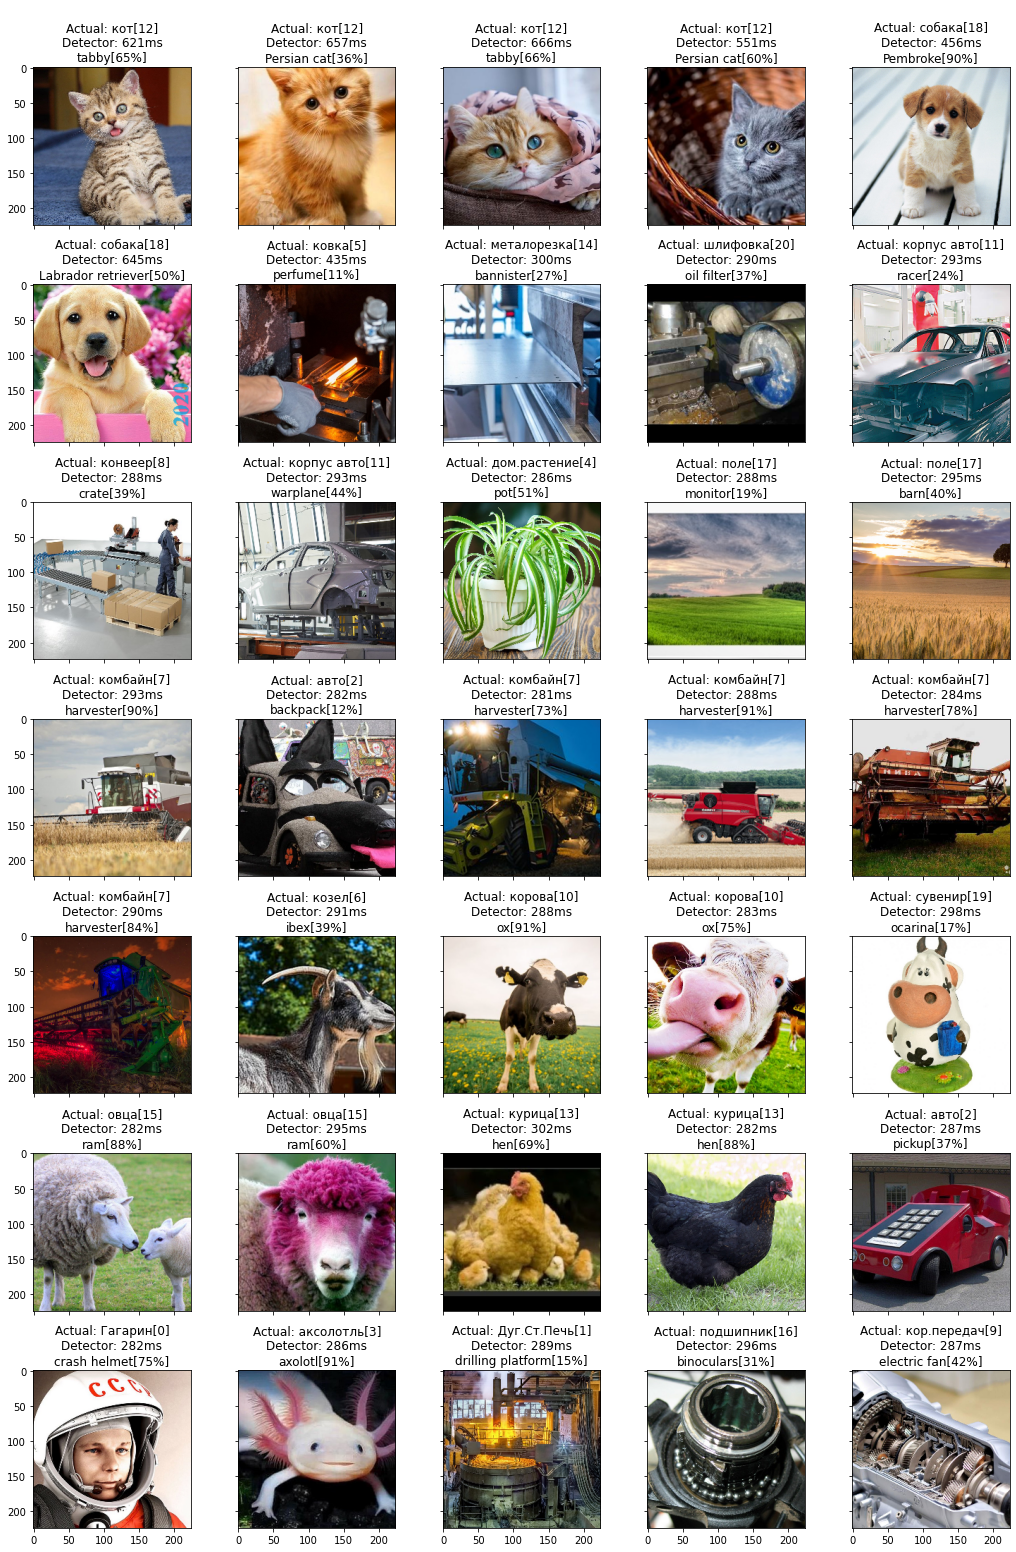

In [6]:
num_per_row = 5
single_size = 3.5
vspace = 0.4

classify(simple, denormalize(simple, transform), num_per_row=num_per_row, single_size=single_size, vspace = vspace,
            labels = simple.classes, model=model['model'], model_labels=model['weights'].meta["categories"],
            debug=True)

# Подготовка датасета для донастройки модели

Предположим, что необходимло разработать "робота", собирающего мусор на улице двух типов - смятые бутылки из под воды и алюминевые банки для последующей переработки. Одной из подсистем такого робата будет система компьютерного зрения, которая должна будет определять, какой объект находится перед камерой (в нашем "учебном" случае это может быть только пластиковая буфтылка из под воды или красная алюминевая банка. В реальной ситуации число типов объектов наверняка будет исчисляться сотнями и тысячами).

Для донастройки библиотечных моделей первым дело необходимо сформировать два датасета, один для настройки выходных слоев нейронной сети, другой - для валидации новой модели (проверки её качества). В обоих случаях датасет помимо самих изображений должен содержать метки классов, к которым эти изображения относятся.

In [7]:
%%writefile train.csv
label;url
bottle;https://thumbs.dreamstime.com/b/hand-woman-plastic-bottle-bottle-caps-littering-environment-rubbish-grass-background-concept-environmental-66329539.jpg
bottle;https://thumbs.dreamstime.com/b/%D0%BF-%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%BD%D1%8B%D0%B5-%D0%B1%D1%83%D1%82%D1%8B-%D0%BA%D0%B8-%D0%BC%D0%B8%D0%BD%D0%B5%D1%80%D0%B0-%D1%8C%D0%BD%D0%BE%D0%B9-%D0%B2%D0%BE-%D1%8B-%D0%BD%D0%B0-%D1%82%D1%80%D0%B0%D0%B2%D0%B5-%D0%B2-%D0%BF%D0%B0%D1%80%D0%BA%D0%B5-%D0%B7%D0%B0%D1%81%D0%B0%D1%80%D0%B8%D0%B2%D0%B0%D1%82%D1%8C-83684883.jpg
bottle;https://image.shutterstock.com/image-photo/empty-plastic-bottles-on-ground-600w-1492801013.jpg
bottle;https://st2.depositphotos.com/3518393/9703/i/950/depositphotos_97034480-stock-photo-plastic-bottles-of-mineral-water.jpg
bottle;https://st2.depositphotos.com/3518393/12355/i/950/depositphotos_123557804-stock-photo-plastic-bottle-of-mineral-water.jpg
bottle;https://avatars.mds.yandex.net/i?id=7ce64bc3d8da7aa9e914715557a1f1c3-5501647-images-thumbs&ref=rim&n=33&w=338&h=225
bottle;https://avatars.mds.yandex.net/i?id=ae8cb27458571d7965294b7bd01dcbe4-4571079-images-thumbs&ref=rim&n=33&w=339&h=225
bottle;https://avatars.mds.yandex.net/i?id=1c2272968ac49de405d9263ef2d98ba7-5869064-images-thumbs&ref=rim&n=33&w=306&h=225
bottle;https://avatars.mds.yandex.net/i?id=c69e593e7e69cb87c5f069b19de17111-5910728-images-thumbs&ref=rim&n=33&w=338&h=225
bottle;https://avatars.mds.yandex.net/i?id=8608be551697e1b422aadf2a63b2bd04-5236457-images-thumbs&ref=rim&n=33&w=338&h=225
cola can;http://levik.com/i/p/2016/ny/cokelitter.jpg
cola can;https://images.squarespace-cdn.com/content/v1/57a3b84220099e5233bf6e06/1478706738460-011AL5D104EN633A35RD/image-asset.jpeg
cola can;https://thumbs.dreamstime.com/z/%D1%81%D0%B1%D1%80%D0%BE%D1%88%D0%B5%D0%BD%D0%BD%D0%B0%D1%8F-%D0%BF%D1%83%D1%81%D1%82%D0%B0%D1%8F-%D0%BA%D0%BE%D0%BD%D1%81%D0%B5%D1%80%D0%B2%D0%BD%D0%B0%D1%8F-%D0%B1%D0%B0%D0%BD%D0%BA%D0%B0-%D0%BA%D0%BE%D0%BA%D0%B0-%D0%BA%D0%BE%D0%BB%D1%8B-%D0%BA%D0%BE%D0%BA%D1%81%D0%B0-%D0%B2-%D1%83%D0%BB%D0%B8%D1%86%D0%B5-%D0%B4%D1%83%D0%B1%D0%BB%D0%B8%D0%BD%D0%B5-148182302.jpg
cola can;https://thumbs.dreamstime.com/z/crushed-coca-cola-tin-can-floor-94962686.jpg
cola can;http://blogga.ru/image/days/20051023/gauss04.jpg
cola can;https://i.ytimg.com/vi/EsjwaeWra5Q/maxresdefault.jpg
cola can;https://gsminfo.com.ua/wp-content/uploads/2022/03/d1f5e5f0a661c4119af7e8ab87871f9259d9ea8c.png
cola can;https://www.nearbyme2.com/wp-content/uploads/2020/08/Aluminum-Cans-1160x653.jpg
cola can;http://justerz.ru/wp-content/uploads/2011/06/cola1.jpg
cola can;https://image.shutterstock.com/image-photo/putrajaya-malaysia-july-14th-2015-260nw-296969408.jpg

Overwriting train.csv


In [8]:
%%writefile test.csv
label;url
bottle;https://www.colinodell.com/sites/default/files/styles/responsive/public/2017-06/rsz_litter-waste-bottle-forest_0.jpg?itok=vlEtkTNP
bottle;https://st4.depositphotos.com/2276657/29346/i/1600/depositphotos_293466072-stock-photo-plastic-bottle-on-ground.jpg
bottle;https://thumbs.dreamstime.com/z/empty-discarded-plastic-water-bottle-forest-laying-dry-leaves-215879287.jpg
bottle;https://thumbs.dreamstime.com/z/%D0%B1%D1%83%D1%82%D1%8B-%D0%BA%D0%B0-%D1%81-%D0%B2%D0%BE-%D0%BE%D0%B9-%D1%8E%D0%B1%D0%B8%D0%BC%D1%87%D0%B8%D0%BA%D0%B0-%D0%BD%D0%B0-%D1%82%D1%80%D0%B0%D0%B2%D0%B5-66683778.jpg
bottle;https://thumbs.dreamstime.com/z/%D0%BF%D0%BB%D0%B0%D1%81%D1%82%D0%BC%D0%B0%D1%81%D1%81%D0%B0-%D1%81%D0%B1%D1%80%D0%BE%D1%88%D0%B5%D0%BD%D0%BD%D0%B0%D1%8F-%D0%BD%D0%B0%D0%BF%D0%B8%D1%82%D0%BA%D0%BE%D0%BC-19082278.jpg
cola can;https://www.nascas.si/wp-content/uploads/2019/01/smeti-odpadki-768x432.jpg
cola can;https://sun9-76.userapi.com/impf/c638421/v638421746/24714/0Z_P4OYW5ms.jpg?size=320x571&quality=96&sign=45238bf82b36735ad1e94e6cd6a70052&c_uniq_tag=Vp8QpTMKfRh11FMK5VNI3l9d58Zj1shiMmShtfS4uJI&type=album
cola can;https://pbs.twimg.com/media/FImbfh6X0AIcqsk.jpg
cola can;https://www.happyhey.com/images/coca-cola-tab/232.jpg
cola can;https://thumbs.dreamstime.com/b/%D0%B1%D0%B5%D0%BB%D0%B0%D1%80%D1%83%D1%81%D1%8C-%D0%BC%D0%B8%D0%BD%D1%81%D0%BA-%D0%BE%D0%B5-%D0%B8%D1%8E%D0%BD%D1%8F-%D0%B6%D0%B5%D1%81%D1%82%D1%8F%D0%BD%D0%B0%D1%8F-%D0%BA%D0%BE%D1%80%D0%BE%D0%B1%D0%BA%D0%B0-coca-cola-%D0%B2-%D1%82%D1%80%D0%B0%D0%B2%D0%B5-%D0%BA%D0%BE%D0%BD%D1%86%D0%B5-%D1%82%D1%80%D0%B0%D0%B2%D1%8B-%D0%B2%D0%B2%D0%B5%D1%80%D1%85-188008802.jpg

Overwriting test.csv


Датасет в библиогтеки PyTorch представлен базовым классом Dataset, описывающий способ загрузки и трансформации набора данных по запросу. 
Начнем с описания процесса "подгрузки" изображений по url и лэйблу из CSV-файла с описанием датасета.

После подготовки класса со сценарием загрузки изображений, его можно проверить путем визуализации с помощью библиотеки Matplotlib.

----------------------------------------------------------------------
Model: SwinTransformer
Number of parameters: 28288354
------------------------------ Train dataset ------------------------------


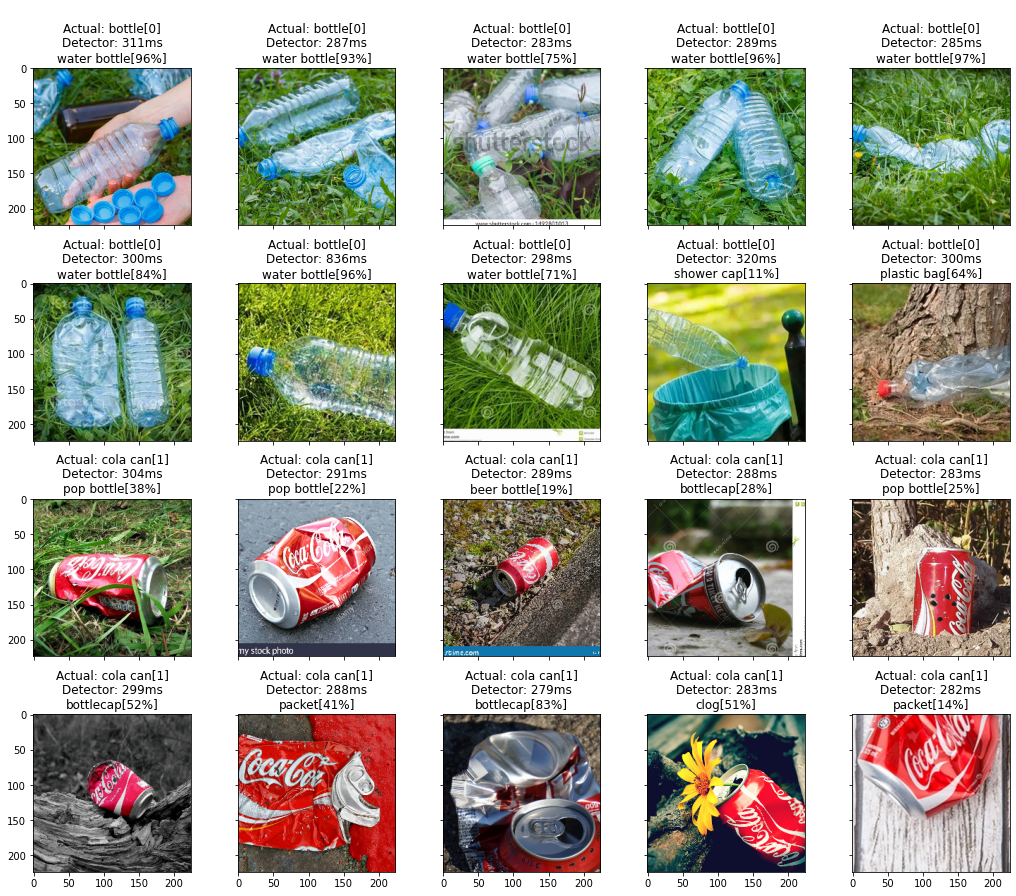

------------------------------ Test dataset ------------------------------


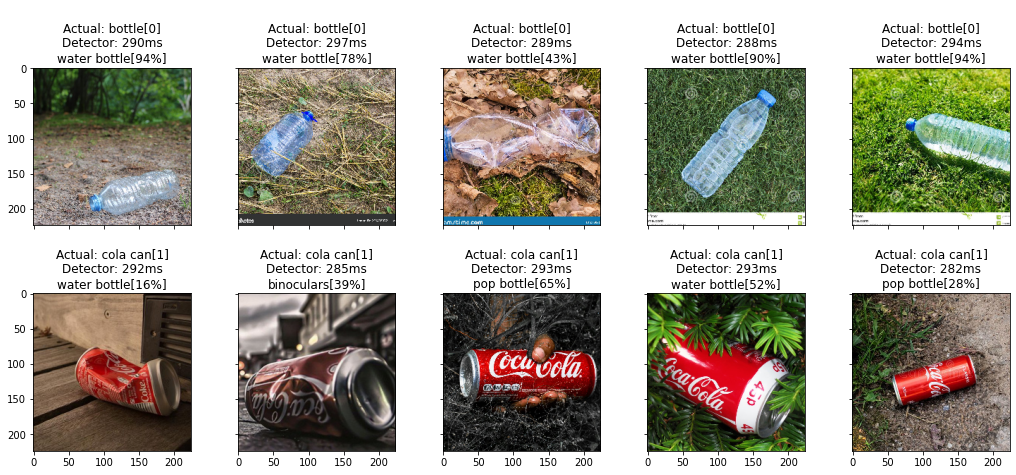

In [9]:
transform = model['preprocess']
train = UrlDataset("train.csv", transform)
test = UrlDataset('test.csv', transform)

num_per_row = 5
single_size = 3.5
vspace = 0.3

print('-'*70)
print(f'Model: { model["model"].__class__.__name__}')
print(f'Number of parameters: {sum(item.numel() for item in model["model"].parameters())}')

print('-'*30  + ' Train dataset ' + '-'*30)
classify(train, denormalize(train, transform), num_per_row=num_per_row, single_size=single_size, vspace=vspace,
            labels = train.classes, model=model['model'], model_labels=model['weights'].meta["categories"])
print('-'*30  + ' Test dataset ' + '-'*30)
classify(test, denormalize(test, transform), num_per_row=num_per_row, single_size=single_size, vspace=vspace,
            labels = test.classes, model=model['model'], model_labels=model['weights'].meta["categories"])

Как видно из результата, зачастую стандартный набор классов известных датасетов не покрывает нужные в специфических задачах. Тем не менее есть эффективный способ донастройки модели, который на практике позволяет с одной стороны воспользоваться результатом оптимизации предобученных моделей, с другой - адаптировать их под специфические задачи.

# Предобученная нейронная сеть как генератор признаков




Наиболее простой способ адаптации предобученных моделей к специфической задаче это переобучение выходного классификатора, который вычисляет принадлежность изображения к тому или иному классу. Это возможно благодаря особенности глубоких нейронных сетей, состоящей в том, что по мере преобразования между слоями происходит постепенный переход от конкретного изображения как набора пикселей к более обощённому представлению (пространство признаков), инвариантных к второстепенной информации (фон, повороты, растяжения, освещенность и т.д.). Таким образом, выходной слой лишь использует обобщённое пространство признаков для разделения на области, относящщиеся к разным классам объектов. И если цель состоит в создании иного разбиения, то достаточно заменить выходной слой на новый классификатор, настроив его на распознавание нужных классов объктов.

Для визуальной проверки возможности применения линейного классификатора можно использовать метод редукции многомерного пространства признаков, полученных на выходе предпоследнего слоя предобученной модели. Для этого с учетом фиксированной последовательности слоев предобученной модели, необходимо отключить слой классификации, заменив его на единичное преобразование. В таком виде модель нейросети будет играть роль генератора признаков.




В первую очередь рассмотрим структуру модели и найдем в ней выходной классификатор

In [10]:
print(model)

{'model': SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(

Выходной слой это classifier (зачастую это даже не один слой, а группа слоев, наделяющих классификатор нужными свойствами).
Уберем его, чтобы получить на выходе набор признаков. Для этого заменим выходной классификатор на единичное преобразование.

In [11]:
image, label = simple[0]
feature_extractor = copy.deepcopy(model['model'])
result = feature_extractor(image.unsqueeze(0)).cpu().detach().squeeze(0).numpy()
print(f'Размерность выходов исходной модели: {result.shape}')
setattr(feature_extractor, model['output_layer'], nn.Identity())
result = feature_extractor(image.unsqueeze(0)).cpu().detach().squeeze(0).numpy()
print(f'Размерность выходов модели после замены выходного классификатора на единичное преобразование: {result.shape}')

Размерность выходов исходной модели: (1000,)
Размерность выходов модели после замены выходного классификатора на единичное преобразование: (768,)


Попробуем визуализировать ккаим-либо образом пространство признаков, обозначая объекты целевых классов разными цветами. Общая гипотеза состоит в том, что  изображения разных классов должны лежать в разных областях пространства признаков (т.е. они выглядят как сосредоточенные "облака" точек, которые в свою очередь расположены на значительном удвлении друг от друга). В этом случае с помощью линейной гиперплоскости можно спроецировать точки в N-мерном пространстве признаков на эту плоскость и получить одно-, двух- или трехмерные проекции этих облаков, которые уже можно визуализировать на графике. Таким образом, для проверки гипотезы достаточно убедиться, что проекции "облаков" разных классов будут визуально изолированы. В этом случае перенастройка линейного классификатора на выходе нейронной сети приведет к решению задачи классификации на индивидуальной выборке объектов.

Чтобы получить двухмерную проекцию точек пространства признаков воспользуемся методом редукции размерности на основе метода линейного PCA (Principial Component Analysis). Суть его состоит в отыскании такой линейной гиперплоскости в N-мерном пространстве, расстояние до которой всех точек будет минимальным (т.е. она максимально аппроксимирует данные). Координаты спроецированных точек в пространстве этой гиперповерхности как раз и являются искомым двухмерным представлением "облаков", характеризующих разные классы объектов выборки.

Итак, первым делом преобразуем имеющиеся списки изображений в массивы признаков и лэйблов классов.

In [12]:
output = []
for image, label in torch.utils.data.ConcatDataset([train, test]):
    result = {'label': label, 'feature': feature_extractor(image.unsqueeze(0)).cpu().detach().squeeze(0).numpy()}
    output.append(result)
features = numpy.concatenate([numpy.expand_dims(record['feature'], 0) for record in output])
labels = [record['label'] for i, record in enumerate(output)]

Далее применим PCA-метод, который на основе N-мерных массивов признаков вычислит координаты точек на гиперплоскости (U), список собственных чисел (S) и собственных векторов (V) для преобразования координат между основным и редуцированным пространством.

In [13]:
totalU, totalS, totalV = torch.pca_lowrank(torch.from_numpy(features), q=2)

Для визуализации остается совершить трансформации осей массивов, чтобы получить ряды для координат абсцис и ординат графика, а также разделить массивы точек разных классов, чтобы каждому задать свой цвет.

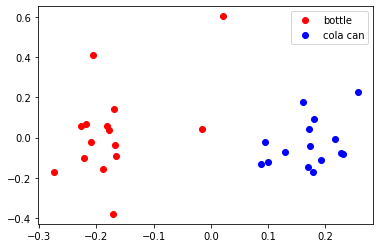

In [14]:
series = {}
for key in ['bottle', 'cola can']:
    points = numpy.concatenate([numpy.expand_dims(totalU[i,:].cpu().detach().numpy(), 0) 
        for i, label in enumerate(labels) if train.classes[label] == key])
    series[key] = numpy.moveaxis(points, 1, 0)

plt.figure()
plt.plot(series['bottle'][0], series['bottle'][1], 'ro', series['cola can'][0], series['cola can'][1], 'bo')
plt.legend(['bottle', 'cola can'])
plt.show()

На графике выше видно, что даже на двухмерной проекции точки разных классов лежат в разных областях и могут быть легко разделены прямой. Это означает, что применение линейного классификатора в данном случае выглядит оправданым.

## Донастройка модели под специфическую задачу классификации

Донастройка происходит за счет переобучения выходных слоев глубинной нейронной сети, отвечающих за различие частных деталей разных классов (https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

Мы будем использовать простейший классификатор - линейный, который играет роль гиперплоскости в N-мерном пространстве, разделющей пространство признаков на 2 части. Преимуществом такого классификатора является его простота, высокая скорость обучения, а также нужный результат даже при небольшом наборе данных (здесь действует эмпирическое правило: чем проще модель, тем меньше данных нужно для её обучения). Основной недостаток линейного классификатора - недостаточная сложность для случаев, когда классы визуально близки, отличаясь только нюансами. В таких ситуациях гиперплоскость является слишком простой моделью и необходимо использовать нелинейную гиперповерхность (нелинейный классификатор).

Так как мы не планируем менять коэффициенты предобученных слоев, первым делом необходимо отключить их перенастройку.

In [15]:
tunned_model = copy.deepcopy(model['model'])
for param in tunned_model.parameters():
    param.requires_grad = False

Затем добавим новый слой-классификатор на выходе

In [16]:
print(getattr(tunned_model, model['output_layer']))

Linear(in_features=768, out_features=1000, bias=True)


In [17]:
in_features = model['in_features'](tunned_model)
print(in_features)

768


Теперь добавим линейный классификатор с нужным числом входов и двумя выходами. Выход классификатора пропустим через Softmax слой, чтобы получить на вызоде нормированный сигнал из диапазона [0;1].

In [18]:
setattr(tunned_model, model['output_layer'], torch.nn.Sequential(torch.nn.Linear(in_features, 2), torch.nn.Softmax(dim=1)))

Для запуска процесса обучения необходим вспомогательный класс-обертка Dataloader, который позволяет объединять и разбивать наборы данных, заданные с помощью Dataset на фрагменты. Это необходимо, например, для параллелизации процесса настройки в ансамблях моделей, когда выборка разбивается на подвыборки и настройка происходит в  независимых процессах.

In [19]:
dataloader = [
    {
        'train': True,
        'loader': DataLoader(train, batch_size=1, shuffle=True, num_workers=1)
    },
    {
        'train': False,
        'loader': DataLoader(test, batch_size=1, shuffle=True, num_workers=1)
    }
]

Создадим критерий, оптимизатор и динамически изменяемый коэффициент усиления процесса обучения.

In [20]:
tunned_model.to(device)
critery = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(getattr(tunned_model, model['output_layer']).parameters(), lr=0.1, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5,verbose=True)

Adjusting learning rate of group 0 to 1.0000e-01.


Наконец, проведем перенастройку

In [21]:
model_conv = train_model(model=tunned_model, dataloader=dataloader, device=device, 
                         critery=critery, optimizer=optimizer, scheduler=lr_scheduler, 
                         num_epochs=9)

Epoch 0/8
----------
Adjusting learning rate of group 0 to 1.0000e-01.
Loss: 0.3590 Acc: 0.9500
Loss: 0.5060 Acc: 0.8000

Epoch 1/8
----------
Adjusting learning rate of group 0 to 1.0000e-01.
Loss: 0.3456 Acc: 0.9500
Loss: 0.3458 Acc: 1.0000

Epoch 2/8
----------
Adjusting learning rate of group 0 to 5.0000e-02.
Loss: 0.4041 Acc: 0.9000
Loss: 0.3133 Acc: 1.0000

Epoch 3/8
----------
Adjusting learning rate of group 0 to 5.0000e-02.
Loss: 0.3133 Acc: 1.0000
Loss: 0.3133 Acc: 1.0000

Epoch 4/8
----------
Adjusting learning rate of group 0 to 5.0000e-02.
Loss: 0.3133 Acc: 1.0000
Loss: 0.3133 Acc: 1.0000

Epoch 5/8
----------
Adjusting learning rate of group 0 to 2.5000e-02.
Loss: 0.3133 Acc: 1.0000
Loss: 0.3133 Acc: 1.0000

Epoch 6/8
----------
Adjusting learning rate of group 0 to 2.5000e-02.
Loss: 0.3619 Acc: 0.9500
Loss: 0.3133 Acc: 1.0000

Epoch 7/8
----------
Adjusting learning rate of group 0 to 2.5000e-02.
Loss: 0.3133 Acc: 1.0000
Loss: 0.3133 Acc: 1.0000

Epoch 8/8
----------
Adj

Выведем результат после обучения

------------------------------ Train dataset ------------------------------


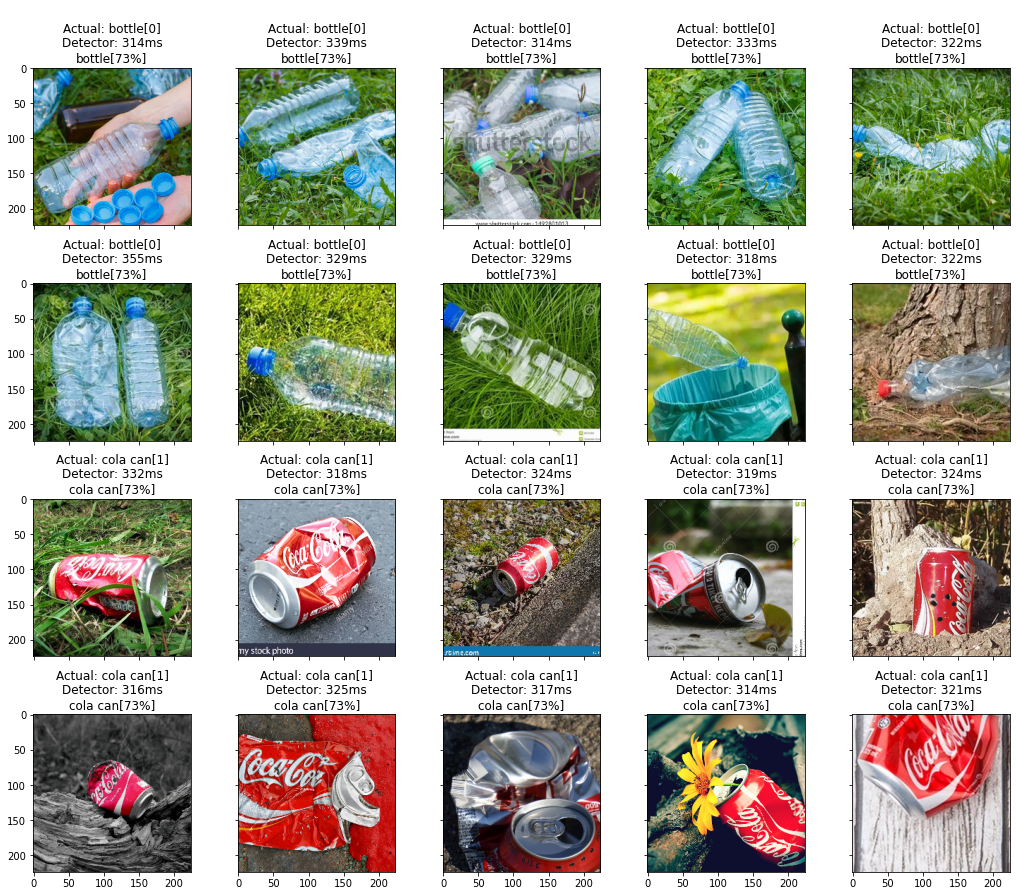

------------------------------ Test dataset ------------------------------


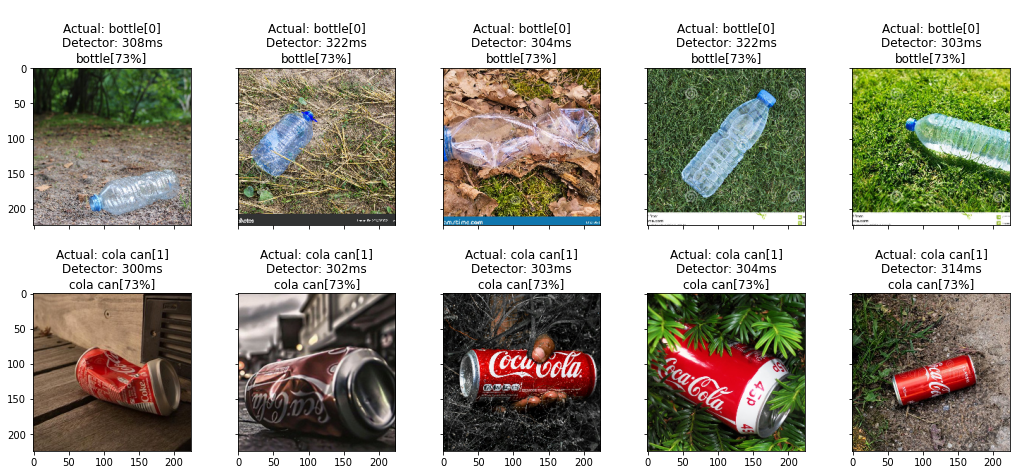

In [22]:
print('-'*30  + ' Train dataset ' + '-'*30)
classify(train, denormalize(train, transform), num_per_row=num_per_row, single_size=single_size, vspace=vspace,
            labels = train.classes, model=tunned_model, model_labels=train.classes)
print('-'*30  + ' Test dataset ' + '-'*30)
classify(test, denormalize(test, transform), num_per_row=num_per_row, single_size=single_size, vspace=vspace,
            labels = test.classes, model=tunned_model, model_labels=test.classes)

## Задание для самостоятельного исследования
1. В заданной индивидуально категории объектов собрать набор изображений (датасет), который будет обладать следующими характеристиками:
- выбрать 2 целевых объекта для распознавания из заданной категории
- для 50% выборки найти в интернете различные изображения объекта из класса 1
- остальные 50% выборки для второго класса
- использовать различную освещенность объектов (день, ночь, сумерки, на рассвете/закате)
- использовать различный угол взгляда (фронтальная, сбоку, сверху, снизу, в 3/4)
Размер датасета - 100 изображений.

2. Сравнить результаты классификации, время индивидуального расчета для 3х  предобученных моделях. Построить графики средней скорости классификации изображений для разных моделей (AlexNet, DenseNet, MobileNet) и сред исполнения (CPU, GPU, TPU).

3. Провести классификацию выбранных изображений с использованием преднастроенных коэффициентов для не менее 3х моделей. В отчете привести примеры успешных/неуспешных результатов (12 примеров - по 3 для каждого класса и успешной/неуспешной классификации). Вычислить общую метрику классификации.

4. Провести донастройку модели на собранный датасет и провести классификацию на выбранном наборе данных. Разбить изображения на часть для настройки (80% датасета) и часть для валидации (20% датасета). В отчете привести примеры успешных/неуспешных результатов (12 примеров - по 3 для каждого класса и успешной/неуспешной классификации). Вычислить общую метрику классификации.